In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')
sys.path.append('D:/Programmation/3I026')
sys.path.append('D:/Programmation/3I026/ml_lastest_small')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

### Génération de données Jouet

Dans un premier temps, nous allons générer une base jouet assez petite (par exemple, 10 exemples de chaque classe).

In [328]:
the_set = ut.createGaussianDataset(np.array([1,1]),np.array([[1,0.75],[0.75,1]]),np.array([-1,-1]),np.array([[1,-0.75],[-0.75,1]]),10)

In [329]:
# the_set = ... # définition d'un LabeledSet avec la fonction précédente

S= the_set.x[np.where(the_set.y == 1),:]
S[0]

array([[ 1.32890333,  1.50795536],
       [ 0.629432  ,  0.57611744],
       [ 1.94482144,  0.82798563],
       [ 1.05267748, -0.59576898],
       [-0.19044744, -0.87992092],
       [ 0.99185526,  0.70688529],
       [ 1.55260712,  2.62719723],
       [ 2.05290535,  1.7248542 ],
       [-0.25624617,  1.50443171],
       [-0.21426497,  1.35609996]])

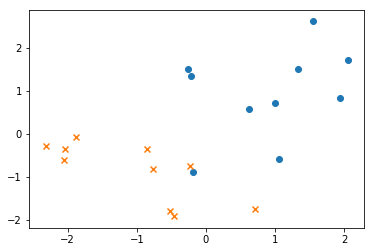

In [330]:
# Affichage du dataset généré
ut.plot2DSet(the_set)

In [331]:
def classe_majoritaire(labeledSet):
    array = np.empty((0,0))
    size = labeledSet.size()
    
    # Permet de récupérer un dictionnaire où la clé est le retour et la valeur le nombre d'occurences
    for i in range(size):
        array = np.append(array,labeledSet.getY(i))
    unique, counts = np.unique(array, return_counts=True)
    
    classe = 1 # Par defaut on renvoie la classe 1 si aucune n'est majoritaire à plus de 50%
    cpt = 0
    
    for i in range (unique.size):
        if (cpt < counts[i]):
            classe = unique[i]
    return classe
    
        

In [332]:
classe_majoritaire(the_set)

1.0

## Arbres de décision

Dans cette étape, on réalise l'implémentation de l'algorithme de construction d'un arbre de décision.

### Entropie et gain d'information

On note $\{c_1, c_2,..., c_k\}$, l'ensemble des classes possibles.

Dans le cours, la mesure de désordre présentée utilise, pour toute valeur $c$ de la classe le ratio $\frac{|Y(c)|}{|Y|}$ qui correspond à la probabilité de la classe $c$ parmi $Y$.
On note dans ce qui suit $p_1$ la probabilité de la classe $c_1$ parmi $Y$, etc. 

Ainsi, on a $P=(p_1, p_2,..., p_k)$ la distribution de probabilités sur les classes ainsi définies.

L'**entropie de Shannon** de la distribution $P$ est donnée par:

$ H_S(P) = -\sum_{i=1}^{k} p_i \log_k(p_i)$

Le logarithme utilisé est le logarithme en base $k$ afin d'obtenir une valeur normalisée de l'entropie. 

*Remarque:* avec les notations vues en cours, on a $D(Y) = H_S(P)$.

Pour ce qui suit, une *distribution de probabilités* est représentée par une **liste** Python $P=[p_1,...,p_k]$ de valeurs réelles telle que
* pour tout $i=1,..., k$ : $0 \leq p_i \leq 1$
* $\sum_{i=1}^{k}p_i = 1$


In [333]:
import math

def shannon(P):
    somme = 0
    iteration = len(P)
    if(iteration == 0):
        return 0
    for i in range (iteration):
        #print(P[i])
        if(P[i] == 1):
            return 0
        if(P[i] != 0):
            #print(P[i],iteration)
            somme += P[i] * math.log(P[i],iteration)
    return -somme



In [334]:
# Exemples d'utilisation:
print("P=[1,0] : ", shannon([1, 0]))
print("P=[0.25, 0.25, 0.25, 0.25] : ", shannon([0.25, 0.25, 0.25, 0.25]))
print("P=[0.7, 0.1, 0.2, 0.0] : ", shannon([0.7, 0.1, 0.2, 0.0]))
print("P=[1.0/3, 2.0/3] : ", shannon([1.0/3, 2.0/3]))

P=[1,0] :  0
P=[0.25, 0.25, 0.25, 0.25] :  1.0
P=[0.7, 0.1, 0.2, 0.0] :  0.5783898247235197
P=[1.0/3, 2.0/3] :  0.9182958340544896


La courbe donnant la valeur de <code>shannon([p, 1-p])</code> en fonction de <code>p</code>.

In [335]:
import matplotlib.pyplot as plt

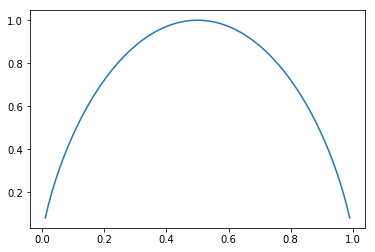

In [336]:
#Permet de créer une matrice de size(100,2) ou chaque ligne correspondra à [p, 1-p]
#p variant de 0.01, 0.99
#p ne peut pas être égal à 0 sinon limite de log = -infini
x1 = np.linspace(0.01,0.99,100) 
x2 = np.linspace(0.99,0.01,100) 

x = np.concatenate((x1,x2), axis=0)
x = x.reshape(2,100)
x = np.swapaxes(x,0,1)




shape = x.shape
size = shape[0]
#print(size)

xRes = []
yRes = []
# Permet de récupérer les parametres X qui donnent les résultat Y
# X = p
# Y = shannon([p, 1-p])
for i in range (size):
    xX = x[i]
    yRes.append(shannon(xX))
    xRes.append(xX[0])
    
#print(xRes)
#print(yRes)

plt.plot(xRes,yRes)
plt.show()

In [337]:
def entropie(labeledSet):
    # Creation d'une array pour stocker les différentes valeurs de retour possible
    array = np.empty((0,0))
    size = labeledSet.size()
    
    # Permet de récupérer un dictionnaire où la clé est le retour et la valeur le nombre d'occurences
    for i in range(size):
        array = np.append(array,labeledSet.getY(i))
    unique, counts = np.unique(array, return_counts=True)
    
    # Probabilité = Nombre d'occurences de chaque parametre / la taille de l'ensemble
    liste_prob = counts/size
    return shannon(liste_prob)
    

In [338]:
entropie(the_set)

1.0

Cette fonction <code>entropie</code> permet dont de calculer le désordre des classes dans le LabeledSet considéré.

### Discrétisation des attributs numériques

Comme on l'a vu en cours, discrétiser un attribut numérique consiste en trouver un seuil de coupure dans son ensemble de valeurs. 

Par exemple, soit l'attribut Age contenant les valeurs 17, 18, 20, 27, 35, 37, 40. On discrétise cet attribut en 2 valeurs en prenant, par exemple, le seuil 30: cela permet de séparer d'un côté les valeurs inférieures ou égales à 30, et de l'autre les valeurs strictement supérieures à 30.

Le seuil est choisi afin d'optimiser la distribution des classes des exemples qui se trouvent de chaque côté du seuil. Une fois un seuil choisi, on calcule le désordre des classes associées aux exemples de chaque côté du seuil et on agrège les 2 valeurs de désordre obtenues pour déterminer la qualité de la coupure à l'aide de la mesure $Q$ vue en cours.


Soit $X$ un ensemble d'exemples, et soit $A$ un attribut que l'on souhaite discrétiser. Pour cela, on constitue l'ensemble des valeurs prises par les exemples de $X$ pour l'attribut $A$. Soit $A_X$ cet ensemble de valeurs.

La discrétisation de $A_X$ s'effectue par les étapes suivantes:
- Etape 1: ordonner de façon croissante les valeurs de $A_X$;
- Etape 2: regarder tous les seuils possibles de coupure entre 2 valeurs consécutives de $A_X$ (on prend comme seuil de coupure la valeur médiane entre ces 2 valeurs). Chaque seuil trouvé créé 2 intervalles qui générent 2 sous-ensembles de $X$: l'ensemble $X_1$ des exemples dont la valeur pour $A$ et inférieure ou égale au seuil, et l'ensemble $X_2$ des exemples dont la valeur pour $A$ et supérieure au seuil. On détermine la qualité du seuil par la mesure de qualité d'un test vue en cours. On note $Q(seuil)$ cette valeur.


La meilleure coupure pour discrétiser $A_X$ est celle qui minimise la valeur $Q(seuil)$.


Par exemple, soit $X=\{17, 18, 20, 27, 35, 37, 40\}$, chaque valeur étant associées aux classes +1, +1, -1, -1, +1, +1, -1 respectivement. Un seuil de coupure possible est $31$ ($31 = \frac{27+35}{2}$). Ce seuil coupe $X$ en $X_1=\{17, 18, 20, 27\}$ et $X_2=\{35, 37, 40\}$.

- pour $X_1$, la probabilité de chaque classe est: $p(+1)= 0.5$ et $p(-1)=0.5$ donc, $H_S(X_1)=1$;
- pour $X_2$, la probabilité de chaque classe est: $p(+1)= \frac{1}{3}$ et $p(-1)=\frac{2}{3}$ donc, $H_S(X_2)=0.9182958340544896$;
- on a donc: $$Q(seuil=31) = \frac{4}{7} H_S(X_1) + \frac{3}{7} H_S(X_2);$$
soit $Q(seuil=31) = 0.9182958340544896$

On considère que <code>the_set</code> est un LabeledSet construit précédement. Il contient deux variables de type array: $x$ et $y$.

In [339]:
ind= np.argsort(the_set.x,axis=0)   # Tri des valeurs de the_set.x selon les colonnes. 
                                    # La fonction rend un numpy.ndarray contenant autant de 
                                    # colonnes que the_set.x et dans chaque colonne, on a 
                                    # la position de l'exemple dans l'ordonnancement croissant.
ind # pour afficher

array([[ 9,  5],
       [19, 11],
       [ 7, 15],
       [17,  8],
       [ 3,  1],
       [ 1, 13],
       [11, 19],
       [ 5,  6],
       [16,  3],
       [13,  7],
       [18,  9],
       [ 8, 17],
       [ 2,  2],
       [15, 10],
       [10,  4],
       [ 6, 18],
       [ 0, 16],
       [12,  0],
       [ 4, 14],
       [14, 12]], dtype=int64)

In [340]:
the_set.x[ind[0:len(the_set.x),0]]  # Rend le numpy.array des exemples de the_set.x ordonnés
                                    # selon les indices donnés dans ind (colonne 0)


array([[-2.3167161 , -0.27940716],
       [-2.0543786 , -0.60352377],
       [-2.04288527, -0.34121698],
       [-1.88293357, -0.07323667],
       [-0.85916969, -0.36168872],
       [-0.76524932, -0.80955148],
       [-0.52070101, -1.78356421],
       [-0.45980966, -1.90150937],
       [-0.25624617,  1.50443171],
       [-0.23162884, -0.73971253],
       [-0.21426497,  1.35609996],
       [-0.19044744, -0.87992092],
       [ 0.629432  ,  0.57611744],
       [ 0.71463415, -1.74249457],
       [ 0.99185526,  0.70688529],
       [ 1.05267748, -0.59576898],
       [ 1.32890333,  1.50795536],
       [ 1.55260712,  2.62719723],
       [ 1.94482144,  0.82798563],
       [ 2.05290535,  1.7248542 ]])

In [341]:
the_set.y[ind[0:len(the_set.y),0]]  # Rend le numpy.array des exemples de the_set.y ordonnés
                                    # selon les indices donnés dans ind (colonne 0)

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1]])

In [342]:
colonne = 1    # numéro de la colonne de the_set.x à considérer
for v_i in ind[0:len(the_set.x)]:
    i = v_i[colonne]
    exem = the_set.getX(i)
    clas = the_set.getY(i)
    print("valeur=",exem[colonne], "classe= ", clas[0])

valeur= -1.9015093734662667 classe=  -1
valeur= -1.783564206872465 classe=  -1
valeur= -1.7424945707499813 classe=  -1
valeur= -0.879920918522697 classe=  1
valeur= -0.8095514756152342 classe=  -1
valeur= -0.7397125326093481 classe=  -1
valeur= -0.6035237667507483 classe=  -1
valeur= -0.5957689819855685 classe=  1
valeur= -0.36168872460646273 classe=  -1
valeur= -0.3412169845409567 classe=  -1
valeur= -0.27940716017062983 classe=  -1
valeur= -0.0732366650759656 classe=  -1
valeur= 0.5761174428010944 classe=  1
valeur= 0.7068852949585132 classe=  1
valeur= 0.8279856331109683 classe=  1
valeur= 1.356099958692182 classe=  1
valeur= 1.504431712806754 classe=  1
valeur= 1.507955360455253 classe=  1
valeur= 1.7248542011938262 classe=  1
valeur= 2.627197227568179 classe=  1


In [343]:
def discretise(LSet, col):
    """ LabelledSet * int -> tuple[float, float]
        Hypothèse: LSet.size() >= 2
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf \
                       + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)

In [344]:
discretise(the_set,0) # le résultat dépend, bien sûr, de la base jouet

(-0.35802791466880224, 0.39001345298901247)

In [345]:
discretise(the_set,1) # le résultat dépend, bien sûr, de la base jouet

(0.2514403888625644, 0.39001345298901247)

Une dernière fonction utile permet de diviser une base d'exemples en 2 sous-bases en utilisant un seuil sur la valeur d'un attribut donné.

In [346]:
def divise(LSet,att,seuil):
    """ LSet: LabeledSet
        att : numéro d'attribut
        seuil : valeur de seuil
        rend le tuple contenant les 2 sous-LabeledSet obtenus par la
        division de LSet selon le seuil sur l'attribut att
    """
    input_dimenssion = LSet.getInputDimension()
    
    # Si la dimension a examiner est plus grande ou égale aux nombre de dimension du labeledset
    # Alors on ne renvoie rien. Probleme de paramètre
    if att >= input_dimenssion:
        return 
    
    
    # LabeledSet de retour
    ls1 = ls.LabeledSet(input_dimenssion)
    ls2 = ls.LabeledSet(input_dimenssion)
    
    
    size = LSet.size()
    
    # Split du LabeledSet selon le critère seuil
    for i in range(size):
        X = LSet.getX(i)
        Y = LSet.getY(i)

        if (X[att] <= seuil):
            ls1.addExample(X,Y)
        else:
            ls2.addExample(X,Y)
    
    return ls1,ls2

In [347]:
Linf, Lsup = divise(the_set,0,-0.5)
print("entropie inférieur:",entropie(Linf)," / entropie supérieur:", entropie(Lsup))
# remarque: les résultats dépendent de votre base jouet...

entropie inférieur: 0  / entropie supérieur: 0.7793498372920852


In [348]:
print("BASE SUPERIEURE")
Lsup.affiche_base()

print()

print("BASE INFERIEURE")
Linf.affiche_base()

BASE SUPERIEURE
Exemple 0
	description :  [1.32890333 1.50795536]
	label :  [1]
Exemple 1
	description :  [0.629432   0.57611744]
	label :  [1]
Exemple 2
	description :  [1.94482144 0.82798563]
	label :  [1]
Exemple 3
	description :  [-0.45980966 -1.90150937]
	label :  [-1]
Exemple 4
	description :  [ 1.05267748 -0.59576898]
	label :  [1]
Exemple 5
	description :  [-0.19044744 -0.87992092]
	label :  [1]
Exemple 6
	description :  [0.99185526 0.70688529]
	label :  [1]
Exemple 7
	description :  [1.55260712 2.62719723]
	label :  [1]
Exemple 8
	description :  [-0.23162884 -0.73971253]
	label :  [-1]
Exemple 9
	description :  [2.05290535 1.7248542 ]
	label :  [1]
Exemple 10
	description :  [ 0.71463415 -1.74249457]
	label :  [-1]
Exemple 11
	description :  [-0.25624617  1.50443171]
	label :  [1]
Exemple 12
	description :  [-0.21426497  1.35609996]
	label :  [1]

BASE INFERIEURE
Exemple 0
	description :  [-0.76524932 -0.80955148]
	label :  [-1]
Exemple 1
	description :  [-0.85916969 -0.361688

### Représentation d'un arbre en Python

Un arbre de décision doit être représenté en Python, pour cela, on utilise la classe <code>ArbreBinaire</code> suivante:

In [349]:
import graphviz as gv
# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz


class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Gauche (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g

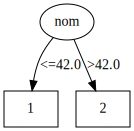

In [350]:
# Exemple d'utilisation: 
un_arbre= ArbreBinaire()
un_arbre.ajoute_feuille(1)
un_arbre.est_feuille()
un_arbre1 = ArbreBinaire()
un_arbre1.ajoute_feuille(2)
un_arbre2 = ArbreBinaire()
un_arbre2.ajoute_fils(un_arbre,un_arbre1,"nom",42.0)

gtree = gv.Digraph(format='png')
un_arbre2.to_graph(gtree)

### Construction de l'arbre de décision

Pour construire un arbre de décision, il faut réaliser les étapes suivantes:
- si l'entropie de Shannon de la distribution des classes de l'ensemble courant est inférieure à epsilon (réel positif fixé et qui est un paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire;
- sinon, pour chaque attribut, calculer le seuil de discrétisation et l'entropie de Shannon correspondante
    - choisir l'attribut qui donne une valeur d'entropie minimale
    - l'attribut choisi sert à constituer un noeud de l'arbre de décision, les arcs issus de ce noeud sont labeller par un test (inférieur ou égal ou supérieur) par rapport au seuil trouvé


In [351]:
def construit_AD(LSet,epsilon):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    
    # Si la condition sur l'entropie est déjà respectée. 
    # Alors nous arrivons au bout de l'arbre. On rend donc une feuille
    if(entropie(LSet) <= epsilon):
        un_arbre = ArbreBinaire()
        classe = classe_majoritaire(LSet)
        un_arbre.ajoute_feuille(classe)
        un_arbre.est_feuille()
        return un_arbre
    
    
    
    parameter = None # Condition sur le parametre X
    entropMin = 2    # Permet de comparer les entropies
    dim = None       # Dimension du parametre X
    
    
    input_dim = LSet.getInputDimension()
    size = LSet.size()
    
    # Récuperation de (parameter,dim)
    for i in range(input_dim):
        entropI = discretise(LSet,i)
        #print("Entropie i ",entropI[1])
        if ( entropMin > entropI[1] ):
            #print("Evaluation : ", i , " // " ,entropI)
            entropMin = entropI[1]
            parameter = entropI[0]
            dim = i
    
    
    #Division des LabeledSet associés aux feuilles
    lsTab = divise(LSet,dim,parameter)
    ls1 = lsTab[0]
    ls2 = lsTab[1]
    
    
    
    #print(entropie(LSet))
    
    
    # Appel récursif pour construire les feuilles.
    un_arbre0 = construit_AD(ls1,epsilon)
    un_arbre1 = construit_AD(ls2,epsilon)
    
    un_arbre2 = ArbreBinaire()
    un_arbre2.ajoute_fils(un_arbre0,un_arbre1,dim,parameter)
    
            
    return un_arbre2


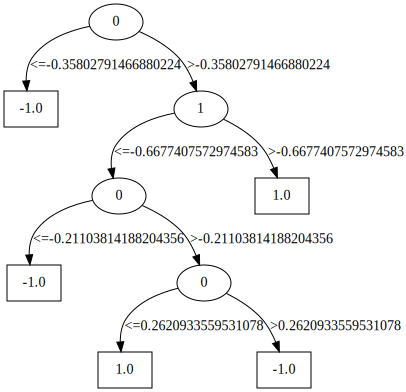

In [352]:
#test de l'affichage 
abin = construit_AD(the_set,0.0)
gtree = gv.Digraph(format='png')
abin.to_graph(gtree)

### Classification avec arbre de décision


Pour classer un nouvel exemple avec un arbre de décision, il faut parcourir l'arbre, de la racine vers une feuille en respectant les tests rencontrés dans chaque arc. Une fois atteint une feuille, la classe de l'exemple est celle présente dans la feuille.

La classe ArbreBinaire contient déjà une fonction <code>classifie</code> qui permet de classer un nouvel exemple et de renvoyer la classe +1 ou -1 selon le cas.

### Implémentation

On définit le classifieur <code>ArbreDecision</code> comme suit.

Si toutes les fonctions précédentes ont été écrites correctement, il est maintenant possible de construire un arbre de décision à partir de la base jouet.


## Applications à des données réelles

In [353]:
class ArbreDecision(cl.Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
        

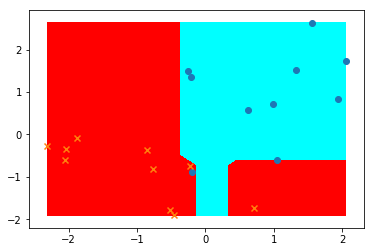

In [354]:
# un exemple d'utilisation:
ad=ArbreDecision(0.0)          # initialiation d'un arbre binaire qui utilisera epsilon= 0.0
ad.train(the_set)              # construction de l'arbre à partir de la base jouet
ut.plot_frontiere(the_set,ad,20)  # tracé graphique de la frontière de décision
ut.plot2DSet(the_set) 

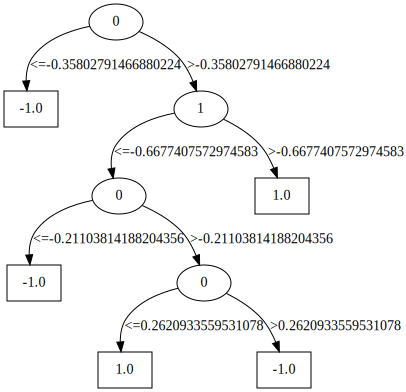

In [355]:
ad.plot()

Taille de la base générée : 200 exemples


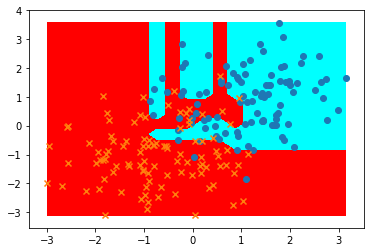

In [356]:
autre_set=ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
print("Taille de la base générée :", autre_set.size(), "exemples")
adautre=ArbreDecision(0.0)          
adautre.train(autre_set)            
ut.plot_frontiere(autre_set,adautre,20)
ut.plot2DSet(autre_set) 

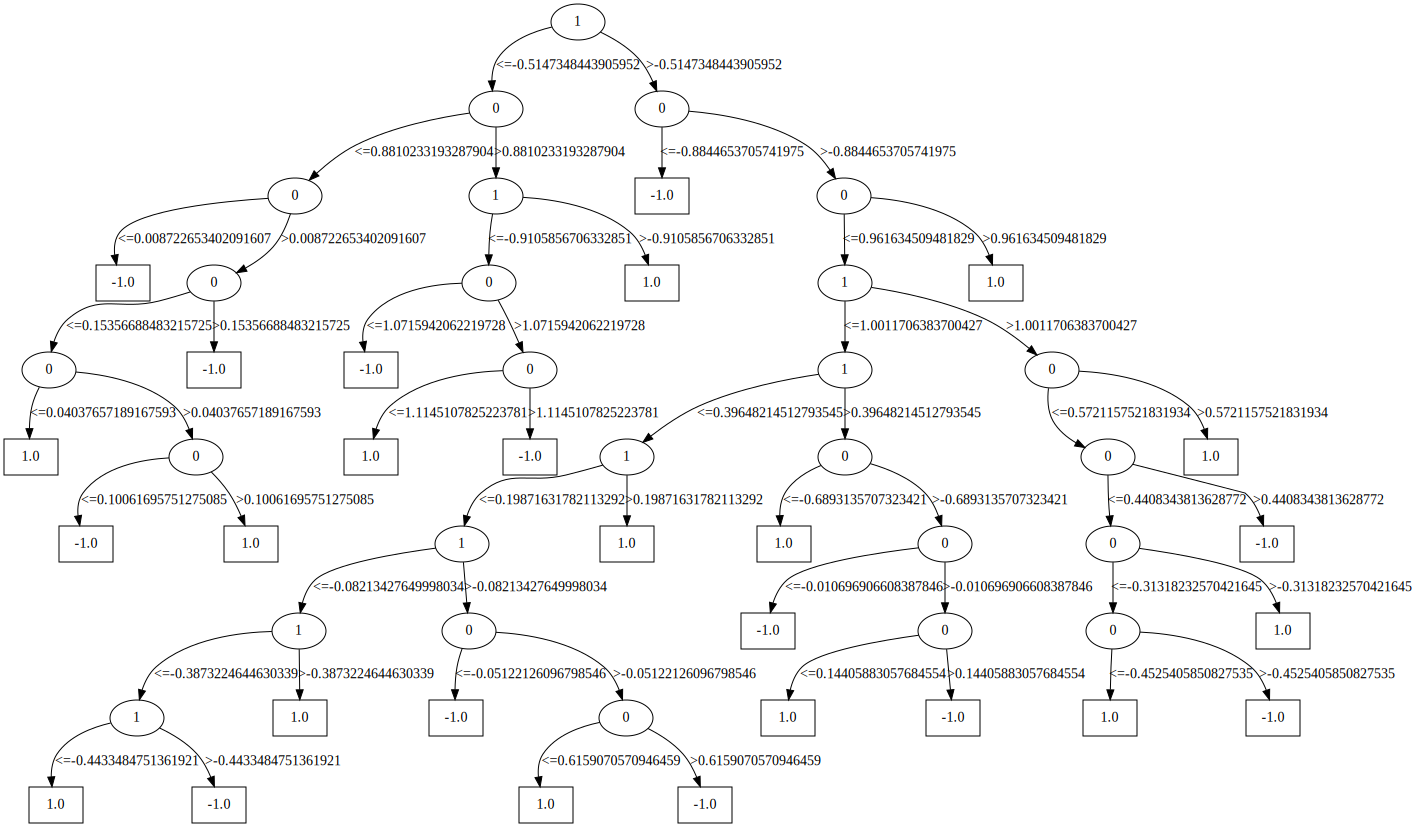

In [357]:
adautre.plot()

# Commentaire : Arbre décisionnel vs Perceptron
Le gros avantage de l'arbre, c'est qu'il est capable d'isoler des classes qui se trouvent entourés d'autres classes.

Dans l'exemple ci dessous. Les croix du coin supérieur gauche sont "entourés" de points.
On remarquera que l'arbre décisionnel a une meilleure accuracy que le perceptron sur cette région où sont entourés les croix. Là ou il faudrait jongler avec un certain kernel pour obtenir un résultat optimal avec un perceptron

In [358]:
class ClassifierPerceptronKernel(cl.Classifier):
    def __init__(self,dimension_kernel,learning_rate,kernel):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        ##TODO
        self.k = kernel
        self.lr = learning_rate
        self.input_dimension = dimension_kernel

        v = np.random.rand(self.input_dimension)     # vecteur aléatoire à input_dimension dimensions
        self.w = (2* v - 1) / np.linalg.norm(v) # on normalise par la norme de v
        #print(self.w)
        
        
    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        z = np.dot(self.k.transform(x), self.w)
        if(z >= 0):
            return 1
        if(z < 0):
            return -1
        
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        
        #print("Before training",self.w)
        
        for k in range(labeledSet.size()):
            lr = self.lr
            x = self.k.transform(labeledSet.getX(k))
            y = labeledSet.getY(k)
            yt = self.predict(labeledSet.getX(k))
            #print(self.w,y,x)

            #print("Accuracy : ",self.accuracy(labeledSet))
            
            self.w = self.w + lr*(y-yt)*x
            
            #print("lr*y*x : ",lr*(y*x))
        #print("After Training",self.w)

class KernelPoly:
    def transform(self,x):
        x1 = x[0]
        x2 = x[1]
        y=np.asarray([1,x1,x2,x1*x1,x2*x2,x1*x2])
        return y




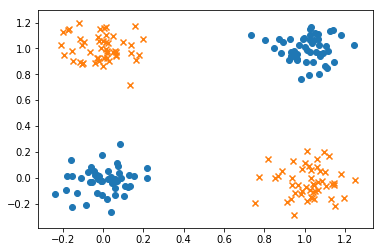

In [359]:
autre_set = ut.createXOR(100,0.01)

ut.plot2DSet(autre_set)

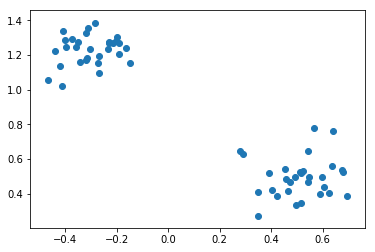

In [360]:
LS = ls.LabeledSet(2)
number_of_points = 30
    
centered_gaussian1 = np.random.multivariate_normal(np.array([-0.3,1.2]),0.01*np.array([[1,0],[0,1]]),number_of_points)
centered_gaussian2 = np.random.multivariate_normal(np.array([0.5,0.5]),0.01*np.array([[1,0],[0,1]]),number_of_points)
for i in range (number_of_points):
    LS.addExample(centered_gaussian1[i],1)
    LS.addExample(centered_gaussian2[i],1)

ut.plot2DSet(LS)

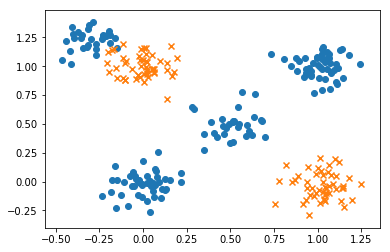

In [361]:
set00 = ut.concatenate(autre_set,LS)
set00 = ut.shuffle_ls(set00)
training_set, testing_set = ut.split_set(set00,70)
ut.plot2DSet(set00)

In [362]:

print("Taille de la base générée :", autre_set.size(), "exemples")
adautre=ArbreDecision(0.0)          
adautre.train(training_set)            
ut.plot_frontiere(testing_set,adautre,20)
ut.plot2DSet(testing_set) 



Taille de la base générée : 200 exemples


In [363]:
acc = adautre.accuracy(testing_set)
print(acc)

98.71794871794872


Accuracy on testing :  74.35897435897436


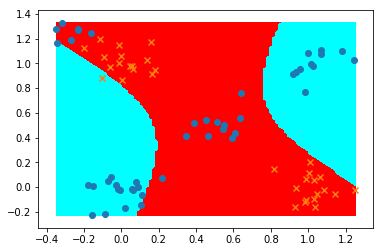

In [364]:

N=100
k=KernelPoly()
perceptron_k=ClassifierPerceptronKernel(6,0.001,k)

##TESTER SUR XOR ET DESSINER LA FRONTIèRE DE DECISION
##TESTER SUR XOR ET DESSINER LA FRONTIèRE DE DECISION
Accuracy0 = []
Accuracy0.append(perceptron_k.accuracy(testing_set))

Accuracy1 = []
Accuracy1.append(perceptron_k.accuracy(training_set))


for i in range(N):
    ut.shuffle_ls(training_set)
    perceptron_k.train(training_set)
    acc = perceptron_k.accuracy(testing_set)
    Accuracy0.append(acc)
    
    acc = perceptron_k.accuracy(training_set)
    Accuracy1.append(acc)

    
plt.plot(Accuracy0)
plt.show()
print("Accuracy on testing : ",perceptron_k.accuracy(testing_set))



ut.plot_frontiere(testing_set,perceptron_k)
ut.plot2DSet(testing_set)